In [1]:
import re
import os
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from netCDF4 import Dataset
import geopandas as gpd
from shapely.geometry import Point
import pandas as pd

# Entire China, Timely Trend

In [2]:
df_2017 = pd.read_csv('/global/scratch/users/liuwenjin021011/data/NOAA_LAI/China_Filtered_2017.csv')
df_2018 = pd.read_csv('/global/scratch/users/liuwenjin021011/data/NOAA_LAI/China_Filtered_2018.csv')
df_2019 = pd.read_csv('/global/scratch/users/liuwenjin021011/data/NOAA_LAI/China_Filtered_2019.csv')

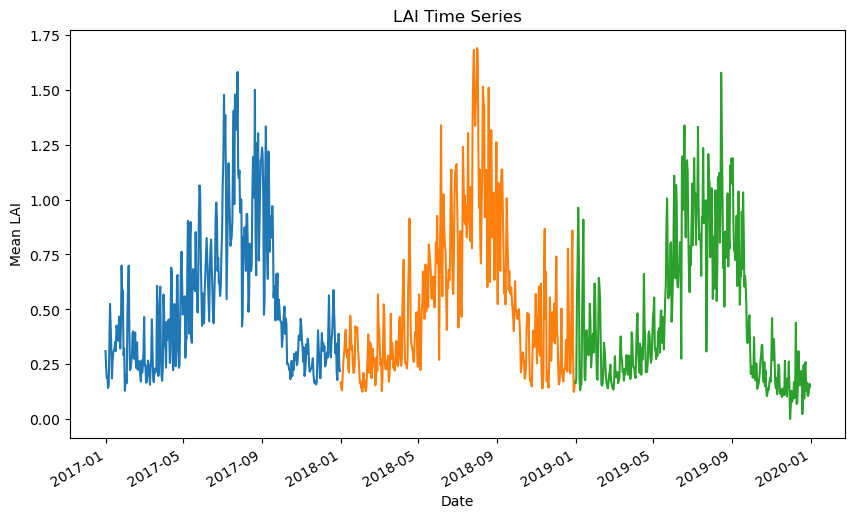

In [3]:
df_2017['Date'] = pd.to_datetime(df_2017[['Year', 'Month', 'Day']])
df_2018['Date'] = pd.to_datetime(df_2018[['Year', 'Month', 'Day']])
df_2019['Date'] = pd.to_datetime(df_2019[['Year', 'Month', 'Day']])

time_series_2017 = df_2017.groupby('Date')['LAI'].mean()
time_series_2018 = df_2018.groupby('Date')['LAI'].mean()
time_series_2019 = df_2019.groupby('Date')['LAI'].mean()

# Plotting the time series
time_series_2017.plot(figsize=(10, 6))
time_series_2018.plot(figsize=(10, 6))
time_series_2019.plot(figsize=(10, 6))
plt.title('LAI Time Series')
plt.xlabel('Date')
plt.ylabel('Mean LAI')
plt.show()

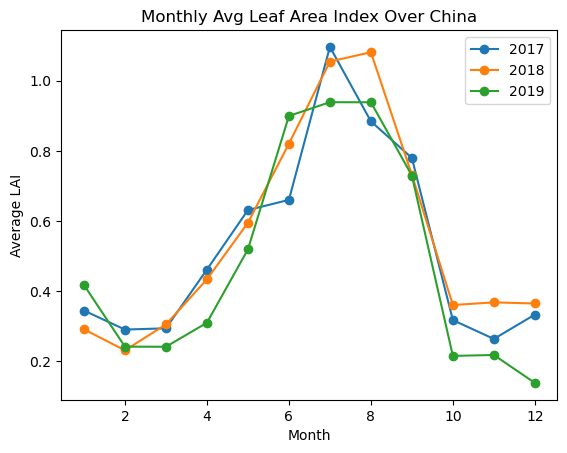

In [5]:
import matplotlib.pyplot as plt

def plot_monthly_lai_trends(df_2017, df_2018, df_2019):
    # Group by month and calculate average LAI for each year
    monthly_avg_2017 = df_2017.groupby('Month')['LAI'].mean()
    monthly_avg_2018 = df_2018.groupby('Month')['LAI'].mean()
    monthly_avg_2019 = df_2019.groupby('Month')['LAI'].mean()

    # Plotting
    plt.plot(monthly_avg_2017.index, monthly_avg_2017.values, marker='o', label='2017')
    plt.plot(monthly_avg_2018.index, monthly_avg_2018.values, marker='o', label='2018')
    plt.plot(monthly_avg_2019.index, monthly_avg_2019.values, marker='o', label='2019')

    plt.xlabel('Month')
    plt.ylabel('Average LAI')
    plt.title('Monthly Avg Leaf Area Index Over China')
    plt.legend()
    plt.show()

# Replace the following with your actual DataFrame objects
# plot_monthly_lai_trends(df_2017, df_2018, df_2019)

plot_monthly_lai_trends(df_2017, df_2018, df_2019)


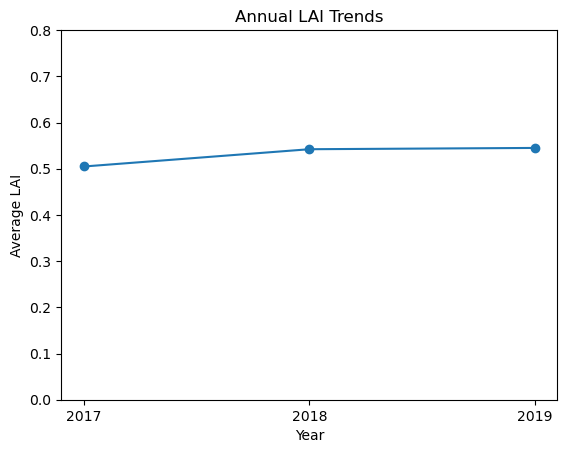

In [17]:
import matplotlib.pyplot as plt

def plot_annual_lai_trends(df_2017, df_2018, df_2019):
    # Calculate average LAI for each year
    avg_lai_2017 = df_2017['LAI'].mean()
    avg_lai_2018 = df_2018['LAI'].mean()
    avg_lai_2019 = df_2019['LAI'].mean()

    # Plotting
    plt.plot(['2017', '2018', '2019'], [avg_lai_2017, avg_lai_2018, avg_lai_2019], marker='o')
    plt.xlabel('Year')
    plt.ylabel('Average LAI')
    plt.title('Annual LAI Trends')
    plt.ylim(0, 0.8)  # Set the start of y-axis to 0
    plt.show()

# Replace the following with your actual DataFrame objects
plot_annual_lai_trends(df_2017, df_2018, df_2019)


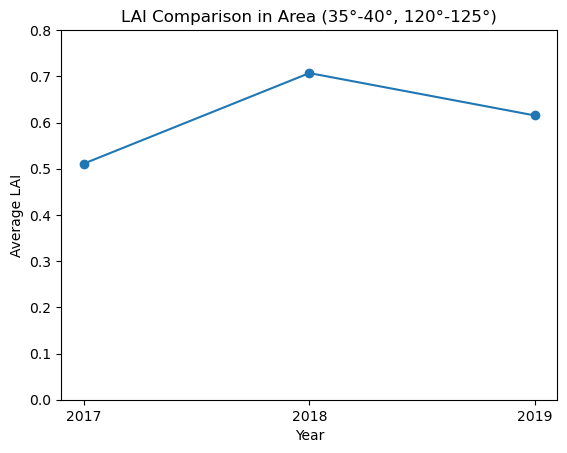

In [18]:
import matplotlib.pyplot as plt

def compare_lai_in_area(lat_min, lat_max, lon_min, lon_max, df_2017, df_2018, df_2019):
    # Filter data within the specified area for each year
    lai_2017 = df_2017[(df_2017['Latitude'] >= lat_min) & (df_2017['Latitude'] <= lat_max) & 
                       (df_2017['Longitude'] >= lon_min) & (df_2017['Longitude'] <= lon_max)]['LAI'].mean()
    lai_2018 = df_2018[(df_2018['Latitude'] >= lat_min) & (df_2018['Latitude'] <= lat_max) & 
                       (df_2018['Longitude'] >= lon_min) & (df_2018['Longitude'] <= lon_max)]['LAI'].mean()
    lai_2019 = df_2019[(df_2019['Latitude'] >= lat_min) & (df_2019['Latitude'] <= lat_max) & 
                       (df_2019['Longitude'] >= lon_min) & (df_2019['Longitude'] <= lon_max)]['LAI'].mean()

    # Plotting
    plt.plot(['2017', '2018', '2019'], [lai_2017, lai_2018, lai_2019], marker='o')
    plt.xlabel('Year')
    plt.ylabel('Average LAI')
    plt.title(f'LAI Comparison in Area ({lat_min}°-{lat_max}°, {lon_min}°-{lon_max}°)')
    plt.ylim(0, 0.8)
    plt.show()

# Replace with actual boundary values
lat_min, lat_max, lon_min, lon_max = 35, 40, 120, 125
compare_lai_in_area(lat_min, lat_max, lon_min, lon_max, df_2017, df_2018, df_2019)



# Geo Trend Divided by Hu Line

In [19]:
# Align the Province Info using Latitude and Longitude based on China-Province-Doundary-Shape.shp

def add_province_info(df, shapefile_path, default_crs='EPSG:4326'):
    """
    Add province information to the dataframe based on latitude and longitude.

    Args:
        df (pd.DataFrame): DataFrame with ['Latitude', 'Longitude', ...] columns.
        shapefile_path (str): Path to the province shapefile.

    Returns:
        pd.DataFrame: Updated DataFrame with an additional 'Province' column.
    """
    # Convert the DataFrame to a GeoDataFrame
    gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df['Longitude'], df['Latitude']))

    # Load the province shapefile
    provinces = gpd.read_file(shapefile_path)
    provinces = provinces[['ADM1_EN', 'geometry']]
    # If the shapefile has no CRS, set a default CRS
    if provinces.crs is None:
        provinces.set_crs(default_crs, inplace=True)

    # Ensure the DataFrame has the same CRS as the shapefile
    if gdf.crs != provinces.crs:
        gdf.set_crs(provinces.crs, inplace=True)

    # Perform spatial join to add the province information
    merged_gdf = gpd.sjoin(gdf, provinces, how='left', op='intersects')

    # Convert back to DataFrame and return
    merged_df = pd.DataFrame(merged_gdf.drop(columns='geometry'))

    return merged_df

shapefile_path = '/global/home/users/liuwenjin021011/logs/fall_2023/China-Province-Doundary-Shape.shp'

In [20]:
# updated_df_2017 = add_province_info(df_2017, shapefile_path)
# updated_df_2017.to_csv('/global/scratch/users/liuwenjin021011/data/NOAA_LAI/China_Filtered_2017.csv')

In [21]:
# updated_df_2018 = add_province_info(df_2018, shapefile_path)
# updated_df_2018.to_csv('/global/scratch/users/liuwenjin021011/data/NOAA_LAI/China_Filtered_2018.csv')

In [22]:
# updated_df_2019 = add_province_info(df_2019, shapefile_path)
#updated_df_2019.to_csv('/global/scratch/users/liuwenjin021011/data/NOAA_LAI/China_Filtered_2019.csv')

In [25]:
# Region I lies west of the Hu Huanyong Line and includes 
# Xinjiang, Tibet, Qinghai, Gansu, Ningxia (most), and Inner Mongolia (most).

set(df_2017['ADM1_EN'])

{'Anhui Province',
 'Beijing Municipality',
 'Chongqing Municipality',
 'Fujian Province',
 'Gansu province',
 'Guangdong Province',
 'Guangxi Zhuang Autonomous Region',
 'Guizhou Province',
 'Hainan Province',
 'Hebei Province',
 'Heilongjiang Province',
 'Henan Province',
 'Hong Kong Special Administrative Region',
 'Hubei Province',
 'Hunan Province',
 'Inner Mongolia Autonomous Region',
 'Jiangsu Province',
 'Jiangxi Province',
 'Jilin Province',
 'Liaoning Province',
 'Ningxia Hui Autonomous Region',
 'Qinghai Province',
 'Shaanxi Province',
 'Shandong Province',
 'Shanghai Municipality',
 'Shanxi Province',
 'Sichuan Province',
 'Taiwan Province',
 'Tianjin Municipality',
 'Tibet Autonomous Region',
 'Xinjiang Uygur Autonomous Region',
 'Yunnan Province',
 'Zhejiang Province'}

In [31]:
df_2017[df_2017['ADM1_EN'] in 

,Unnamed: 0,Latitude,Longitude,LAI,Year,Month,Day,Date,index_right,ADM1_EN
1,1,53.125000,120.774994,3.155,2017,6,10,2017-06-10,14,Inner Mongolia Autonomous Region
2,2,52.774998,120.125000,3.978,2017,6,10,2017-06-10,14,Inner Mongolia Autonomous Region
3,3,52.774998,120.174990,3.926,2017,6,10,2017-06-10,14,Inner Mongolia Autonomous Region
6,6,52.725000,120.074980,4.799,2017,6,10,2017-06-10,14,Inner Mongolia Autonomous Region
7,7,52.725000,120.125000,4.630,2017,6,10,2017-06-10,14,Inner Mongolia Autonomous Region
...,...,...,...,...,...,...,...,...,...,...
27655426,27655426,37.524998,104.475006,0.148,2017,2,19,2017-02-19,14,Inner Mongolia Autonomous Region
27655427,27655427,37.524998,104.524994,0.149,2017,2,19,2017-02-19,14,Inner Mongolia Autonomous Region
27655560,27655560,37.475000,104.174990,0.144,2017,2,19,2017-02-19,14,Inner Mongolia Autonomous Region
27655561,27655561,37.475000,104.225006,0.143,2017,2,19,2017-02-19,14,Inner Mongolia Autonomous Region


In [45]:
def Find_West_East_of_Hu_Ling(string):
    
    West_of_Hu_Line = ['Xinjiang Uygur Autonomous Region', 'Tibet Autonomous Region', 'Qinghai Province', 'Gansu province', 'Ningxia Hui Autonomous Region', 'Inner Mongolia Autonomous Region']
    if string in West_of_Hu_Line:
        return 'West'
    else:
        return 'East'

In [46]:
df_2017['Location'] = df_2017['ADM1_EN'].apply(Find_West_East_of_Hu_Ling)
df_2018['Location'] = df_2018['ADM1_EN'].apply(Find_West_East_of_Hu_Ling)
df_2019['Location'] = df_2019['ADM1_EN'].apply(Find_West_East_of_Hu_Ling)

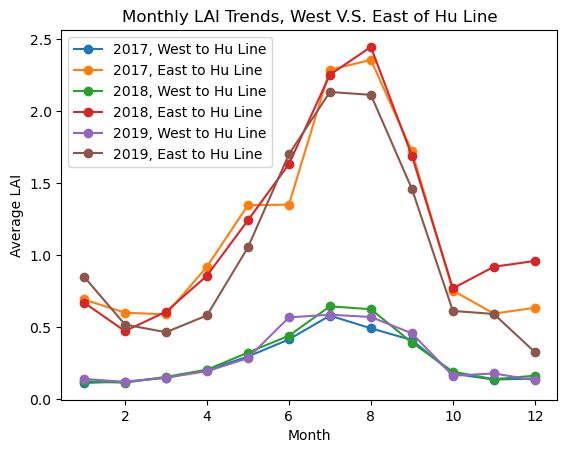

In [53]:

def plot_monthly_lai_trends_with_hu_line(df_2017, df_2018, df_2019):
    # Group by month and calculate average LAI for each year
    df_2017_west = df_2017[df_2017['Location'] == 'West']
    df_2017_east = df_2017[df_2017['Location'] == 'East']
    df_2018_west = df_2018[df_2018['Location'] == 'West']
    df_2018_east = df_2018[df_2018['Location'] == 'East']
    df_2019_west = df_2019[df_2019['Location'] == 'West']
    df_2019_east = df_2019[df_2019['Location'] == 'East']
    
    monthly_avg_2017_west = df_2017_west.groupby('Month')['LAI'].mean()
    monthly_avg_2017_east = df_2017_east.groupby('Month')['LAI'].mean()
    monthly_avg_2018_west = df_2018_west.groupby('Month')['LAI'].mean()
    monthly_avg_2018_east = df_2018_east.groupby('Month')['LAI'].mean()
    monthly_avg_2019_west = df_2019_west.groupby('Month')['LAI'].mean()
    monthly_avg_2019_east = df_2019_east.groupby('Month')['LAI'].mean()

    # Plotting
    plt.plot(monthly_avg_2017_west.index, monthly_avg_2017_west.values, marker='o', label='2017, West to Hu Line')
    plt.plot(monthly_avg_2017_east.index, monthly_avg_2017_east.values, marker='o', label='2017, East to Hu Line')
    plt.plot(monthly_avg_2018_west.index, monthly_avg_2018_west.values, marker='o', label='2018, West to Hu Line')
    plt.plot(monthly_avg_2018_east.index, monthly_avg_2018_east.values, marker='o', label='2018, East to Hu Line')
    plt.plot(monthly_avg_2019_west.index, monthly_avg_2019_west.values, marker='o', label='2019, West to Hu Line')
    plt.plot(monthly_avg_2019_east.index, monthly_avg_2019_east.values, marker='o', label='2019, East to Hu Line')
    
    plt.xlabel('Month')
    plt.ylabel('Average LAI')
    plt.title('Monthly LAI Trends, West V.S. East of Hu Line')
    plt.legend()
    plt.show()

# Replace the following with your actual DataFrame objects
# plot_monthly_lai_trends(df_2017, df_2018, df_2019)

plot_monthly_lai_trends_with_hu_line(df_2017, df_2018, df_2019)